In [1]:
import time

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import EfficientSU2
import qiskit_algorithms.optimizers as optim
from qiskit.primitives import BackendSampler
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer import noise

from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_aer import AerSimulator

In [2]:
iris_data = load_iris()

features = iris_data.data
labels = iris_data.target

# rescale the features
features = MinMaxScaler().fit_transform(features)

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [3]:
num_features = features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = EfficientSU2(num_qubits=num_features, reps=3)

In [4]:
optimizer = optim.COBYLA(maxiter=100)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title(f"Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

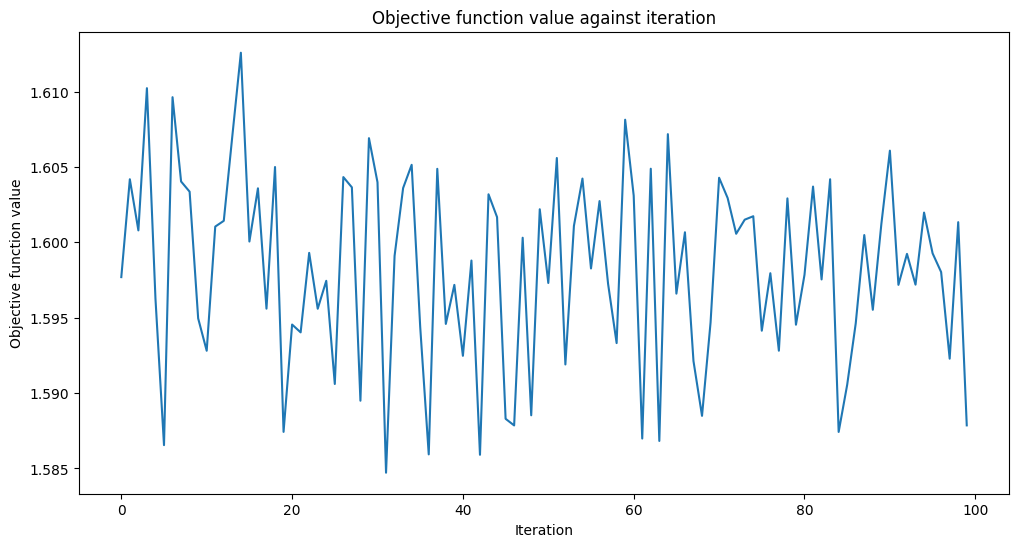

In [5]:
import numpy as np

# depolarizing noise levels
dep1_noise_levels = np.linspace(0, 1, 100)
dep2_noise_levels = np.linspace(0, 1, 100)
dep_scores = []

for i in range(len(dep1_noise_levels)):
    noise_model = noise.NoiseModel()

    dep1_error = noise.depolarizing_error(dep1_noise_levels[i], 1)
    dep2_error = noise.depolarizing_error(dep2_noise_levels[i], 2)

    noise_model.add_all_qubit_quantum_error(dep1_error, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(dep2_error, ['cx'])

    simulator = AerSimulator(noise_model=noise_model)
    vqc = VQC(
        sampler=BackendSampler(backend=simulator),
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph
    )

    objective_func_vals = []
    vqc.fit(train_features, train_labels)

    tr_score = vqc.score(train_features, train_labels)
    te_score = vqc.score(test_features, test_labels)

    dep_scores.append((tr_score, te_score))

with open('dep_scores.npy', 'wb') as f:
    np.save(f, dep_scores)

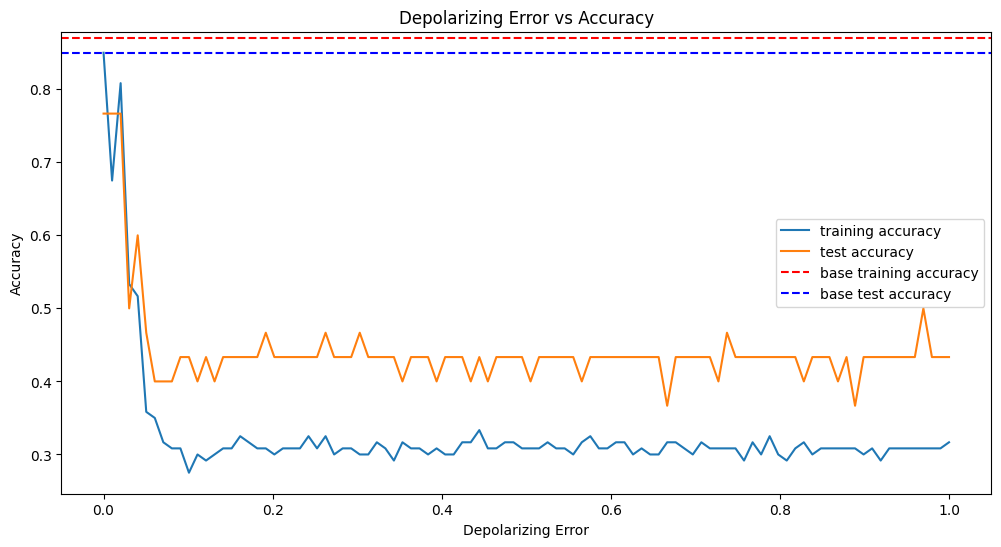

In [7]:
plt.rcParams["figure.figsize"] = (12, 6)
base_tr_acc, base_te_acc = 0.85, 0.87

plt.title("Depolarizing Error vs Accuracy")
plt.xlabel("Depolarizing Error")
plt.ylabel("Accuracy")
plt.plot(dep1_noise_levels, [sc[0] for sc in dep_scores], label="training accuracy")
plt.plot(dep1_noise_levels, [sc[1] for sc in dep_scores], label="test accuracy")

plt.axhline(y=base_te_acc, color='r', linestyle='--', label="base training accuracy")
plt.axhline(y=base_tr_acc, color='b', linestyle='--', label="base test accuracy")

plt.legend()
plt.show()